In [116]:
import os
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
# from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input


In [117]:
# Chargement de la fonction d'importation et formattage des images
from data_loading_and_pretreatments.data_importation_and_formatting_v2 import set_img_size, load_masked_img_multiple_cond

In [118]:
# Chargement du script de séparation des données
from train_val_test_split import train_val_test_split

In [119]:
data_folder = "../data"
conditions = ["Viral Pneumonia", "Lung_Opacity", "COVID",  "Normal"]
img_folder = "images"

lst_dirs_condition = [os.path.join(data_folder, cond, "images") for cond in conditions]

list_dir_images = pd.DataFrame({"img_type" : ["Viral Pneumonia", "Lung Opacity", "Covid", "Normal"],
                                 "img_dir" : lst_dirs_condition})


In [120]:
# Choix de la résolution des images à charger
IMG_SIZE = 256
set_img_size(IMG_SIZE)
print("IMG_SIZE = ", IMG_SIZE) 

IMG_SIZE =  256


## Importation et préparation des données

In [121]:
## Importation des images
SAMPLE_SIZE = 2500
sample_size_viral_pneum = int(np.min([1345, SAMPLE_SIZE/2]))
sample_size_lung_opa = SAMPLE_SIZE - sample_size_viral_pneum
masked_img, labels = load_masked_img_multiple_cond(selected_conditions=conditions, sample_sizes=[sample_size_viral_pneum, sample_size_lung_opa, SAMPLE_SIZE, SAMPLE_SIZE])
print(masked_img.shape)

(7500, 256, 256, 1)


In [122]:
labels = list(map(lambda x: x.replace('Viral Pneumonia', 'Pulmonary infection'), labels))
labels = list(map(lambda x: x.replace('Lung_Opacity', 'Pulmonary infection'), labels))

In [123]:
Counter(labels)

Counter({'Pulmonary infection': 2500, 'COVID': 2500, 'Normal': 2500})

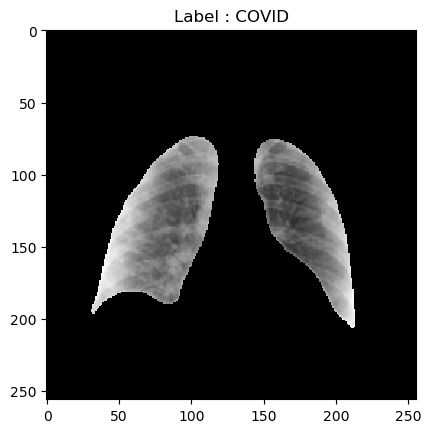

In [125]:
ind = random.sample(range(0,masked_img.shape[0]),1)
plt.imshow(masked_img[ind][0][:,:,0], cmap='gray')
plt.title(f"Label : {labels[ind[0]]}");

## Séparation en échantillons d'apprentissage, de validation et de test

In [126]:
## Reshaping des images pour correspondre au format couleur pour l'intégration dans VGG
X = np.repeat(masked_img,3,-1)/255
y = labels

# Encodage de la variable cible en numérique
labenc = LabelEncoder()
y = labenc.fit_transform(y)
print(labenc.classes_)

# Séparation des échantillons
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, 
                                                                      y,
                                                                      test_val_sizes=(0.2, 0.2), random_state=42)

['COVID' 'Normal' 'Pulmonary infection']


In [129]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [130]:
print(X_train.shape[0],X_train.shape[0]/7500)
print(X_val.shape[0], X_val.shape[0]/7500)
print(X_test.shape[0], X_test.shape[0]/7500)


4800 0.64
1200 0.16
1500 0.2


## Modélisation

### Data augmentation

In [131]:
BATCH_SIZE = 64 


train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

val_datagen = ImageDataGenerator()


train_dataset = train_datagen.flow(X_train,
                                   y_train,
                        batch_size = BATCH_SIZE)


val_dataset = val_datagen.flow(X_val, y_val, batch_size = BATCH_SIZE)

### Construction du modèle

In [ ]:
pre_trained_model = VGG16(weights = 'imagenet', include_top=False, input_shape = (IMG_SIZE, IMG_SIZE, 3))
for layer in pre_trained_model.layers:
    layer.trainable = False
for layer in pre_trained_model.layers[-4:]:
    layer.trainable = True

In [ ]:
pre_trained_model.layers

In [19]:
model = Sequential()

model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax')) 

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) 

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [22]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 5,
                               mode = 'min')

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                        factor = 0.1,
                                        patience = 3,
                                        min_delta = 0.01,
                                        cooldown = 4,
                                        verbose = 1)

callbacks_list = [early_stopping,reduce_learning_rate]

In [23]:
model_history = model.fit(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
            validation_data = val_dataset, # use augmented images for test  
            validation_steps = X_val.shape[0]//BATCH_SIZE,
            epochs = 60,
            callbacks = callbacks_list,
            verbose=True)

#5h45

Epoch 1/60
75/75 [==============================] - 1309s 17s/step - loss: 1.1038 - acc: 0.3558 - val_loss: 0.9933 - val_acc: 0.5825 - lr: 0.0010
Epoch 2/60
75/75 [==============================] - 1289s 17s/step - loss: 0.9472 - acc: 0.5506 - val_loss: 0.8726 - val_acc: 0.5903 - lr: 0.0010
Epoch 3/60
75/75 [==============================] - 1293s 17s/step - loss: 0.8732 - acc: 0.6081 - val_loss: 0.8170 - val_acc: 0.6398 - lr: 0.0010
Epoch 4/60
75/75 [==============================] - 1291s 17s/step - loss: 0.8363 - acc: 0.6394 - val_loss: 0.7310 - val_acc: 0.6884 - lr: 0.0010
Epoch 5/60
75/75 [==============================] - 1287s 17s/step - loss: 0.7320 - acc: 0.6938 - val_loss: 0.6409 - val_acc: 0.7309 - lr: 0.0010
Epoch 6/60
75/75 [==============================] - 1287s 17s/step - loss: 0.6038 - acc: 0.7575 - val_loss: 0.6120 - val_acc: 0.7300 - lr: 0.0010
Epoch 7/60
75/75 [==============================] - 1286s 17s/step - loss: 0.5634 - acc: 0.7763 - val_loss: 0.7996 - val_acc

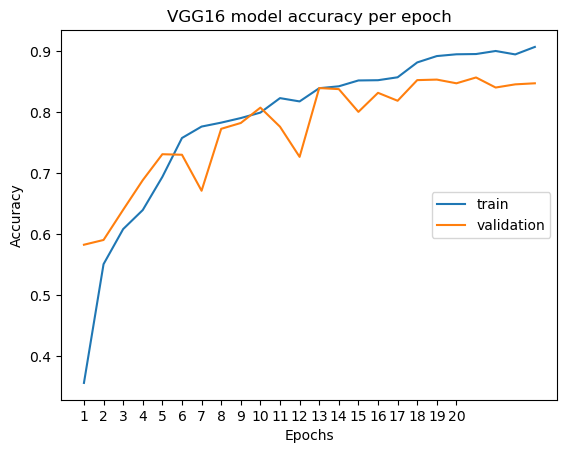

In [25]:
train_acc = model_history.history['acc'] 
val_acc = model_history.history['val_acc']
n_ep = len(val_acc)
plt.plot(np.arange(1,n_ep+1),train_acc, label='train')
plt.plot(np.arange(1,n_ep+1),val_acc, label='validation')
plt.title('VGG16 model accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,21))
plt.legend(loc='right')


In [ ]:
y_val_pred = model.predict(X_val)

38/38 [==============================] - 233s 6s/step


In [ ]:
pred_class_val = y_val_pred.argmax(axis=1)
true_class_val = y_val.argmax(axis=1)
print(classification_report(true_class_val, pred_class_val))


              precision    recall  f1-score   support

           0       0.85      0.86      0.85       371
           1       0.85      0.91      0.88       391
           2       0.91      0.85      0.88       438

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



### Evaluation des performances sur l'échantillon de test

In [ ]:
y_test_pred = model.predict(X_test)
pred_class_test = y_test_pred.argmax(axis=1)
true_class_test = y_test.argmax(axis=1)
print(classification_report(true_class_test, pred_class_test))

47/47 [==============================] - 302s 6s/step
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       492
           1       0.81      0.88      0.85       481
           2       0.90      0.84      0.87       527

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



In [ ]:
f1_score(true_class_test, pred_class_test, average='macro')

0.8513333333333334

# Interprétation du modèle par GradCam

In [13]:
from interpretability.gradcam import make_gradcam_heatmap, save_and_display_gradcam

In [75]:
# Sélection de n images de test sur lesquelle appliquer la méthode GradCam

test_img_selection_indices = random.sample(range(0, X_test.shape[0]), 6)

test_imgs = X_test[test_img_selection_indices]
y_test_imgs = y_test[test_img_selection_indices,:]
test_img_labels = np.argmax(y_test_imgs, axis=1)

pd.Series(test_img_labels).value_counts()

2    2
1    2
0    2
dtype: int64

In [77]:
y_pred_img_tests = model.predict(test_imgs)
pred_img_tests = y_pred_img_tests.argmax(axis=1)
print("Taux de bonnes prédictions : ", np.mean(pred_img_tests == test_img_labels))
pred_img_tests, test_img_labels

1/1 [==============================] - 1s 1s/step
Taux de bonnes prédictions :  1.0


(array([2, 1, 1, 2, 0, 0], dtype=int64),
 array([2, 1, 1, 2, 0, 0], dtype=int64))

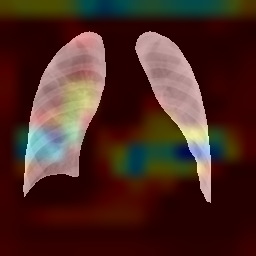

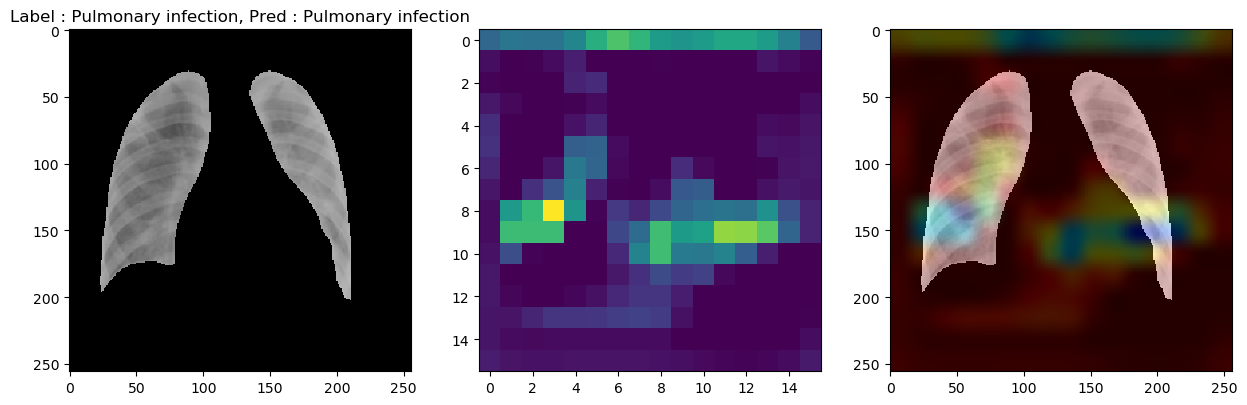

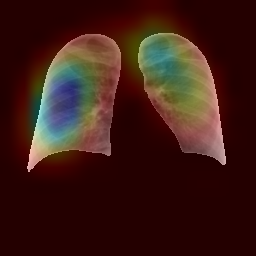

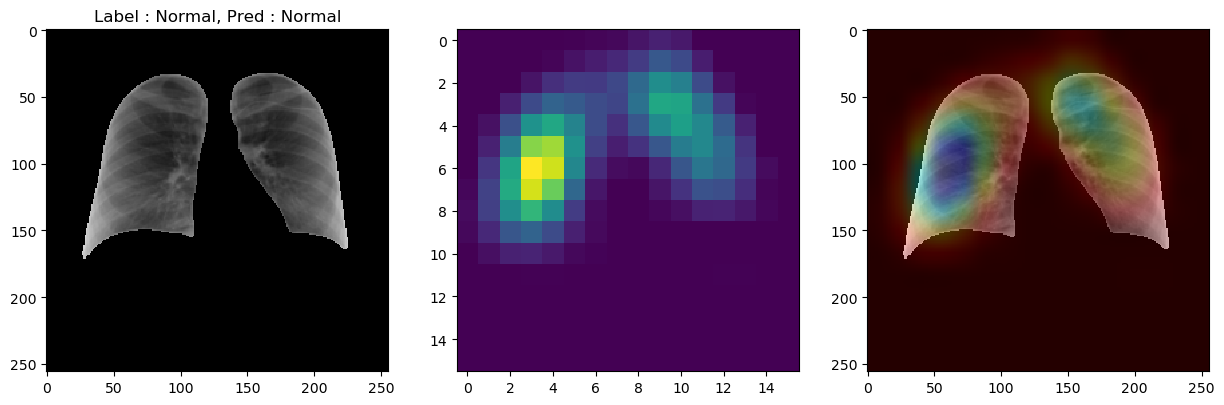

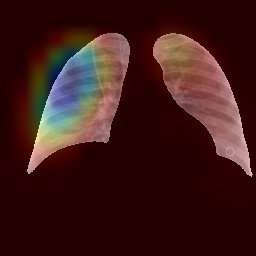

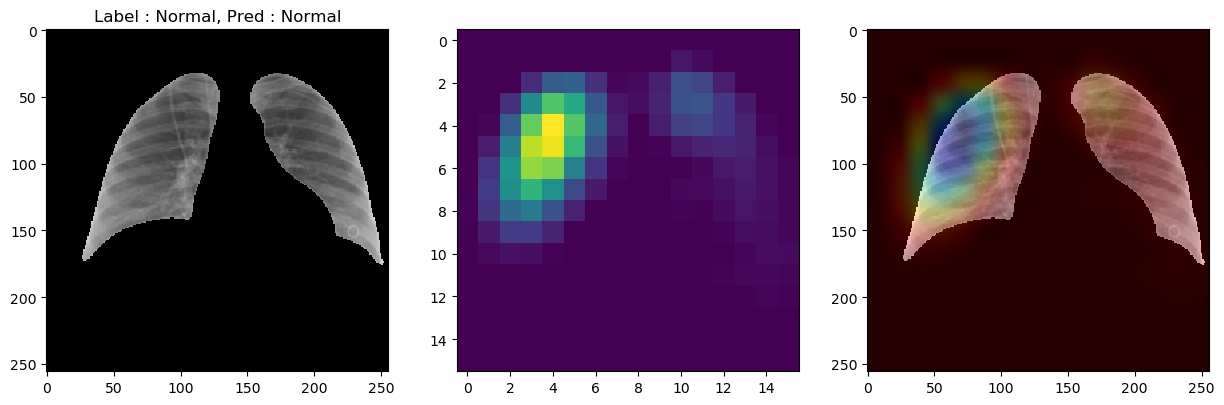

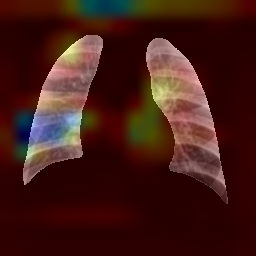

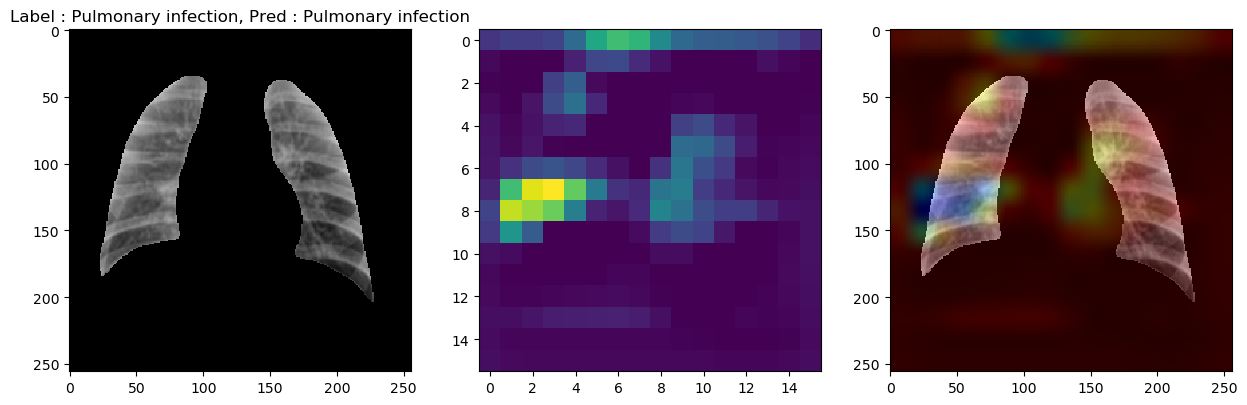

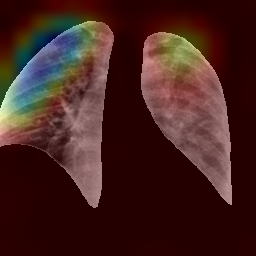

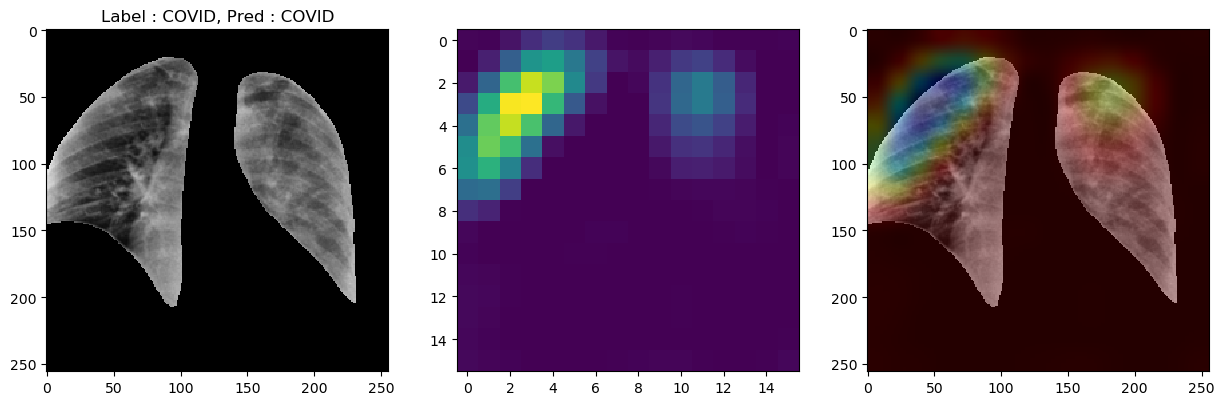

c:\Users\Emilie\Documents\Formation Datascientest\Projet Analyse Pulmonaire\Code\mai24_bds_analyse_pulmonaire\notebooks\interpretability\gradcam.py:87: RuntimeWarning: invalid value encountered in divide
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)


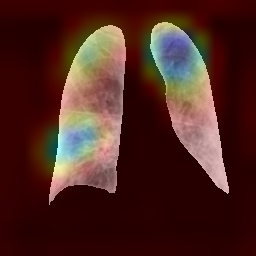

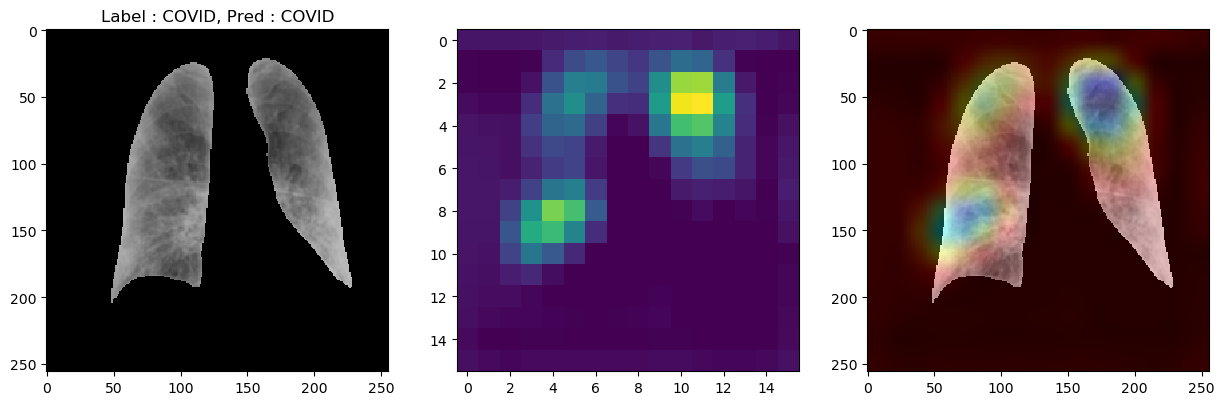

In [79]:
for i in range(0, len(test_img_selection_indices)):
    img_test = test_imgs[i]
    img_test_y = test_img_labels[i]
    img_test_label = labenc.classes_[img_test_y]
    model_pred = pred_img_tests[i]

    heatmaps = make_gradcam_heatmap(
    img_array = np.array([img_test]), 
    model = model, 
    last_conv_layer_name = 'block5_conv3', 
    classifier_layer_names = ['global_average_pooling2d', 'flatten', 'dense', 'dropout', 'dense_1', 'dense_2'],
    class_indices = [0,1,2]
    )
    img_name = f"img_test_{img_test_label}_{i}"
    heatmap_test = heatmaps[model_pred]['heatmap']
    grad_res = save_and_display_gradcam(img_array = img_test, 
                            img_name = img_name, 
                            heatmap = heatmap_test, 
                            alpha=0.4)
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.imshow(img_test)
    plt.title(f"Label : {img_test_label}, Pred : {labenc.classes_[model_pred]}");
    plt.subplot(132)
    plt.imshow(heatmap_test)
    plt.subplot(133)
    plt.imshow(grad_res)
    plt.show()


# Enregistrement du modèle

In [26]:
# Enregistrement du modèle entraîné
model.save("../models/transfer-learning-models/vgg16_3classes_res256_DAini_24epochs")

# # vgg16model = load_model("../models/transfer-learning-models/vgg16_3classes_res256_DAini_24epochs")

# # X_test_3 = np.repeat(np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE,1),3,-1)

# # test_loss, test_acc = vgg16model.evaluate(X_test_3, y_test, verbose=2)



INFO:tensorflow:Assets written to: ../models/transfer-learning-models/vgg16_3classes_res256_DAini_24epochs\assets


INFO:tensorflow:Assets written to: ../models/transfer-learning-models/vgg16_3classes_res256_DAini_24epochs\assets
